**Table of contents**<a id='toc0_'></a>    
- [Mise en place](#toc1_)    
  - [Chargement des données](#toc1_1_)    
  - [Préparation des données](#toc1_2_)    
  - [Vectorisation](#toc1_3_)    
  - [LDA](#toc1_4_)    
- [Score Jaccard](#toc2_)    
- [Classification One vs Rest, régression logistique](#toc3_)    
  - [Nombre de tags prédits](#toc3_1_)    
- [Approche *word embedding*](#toc4_)    
  - [Pré-traitement commun](#toc4_1_)    
  - [Pipeline d'évaluation](#toc4_2_)    
  - [Test avec CountVectorizer](#toc4_3_)    
- [Word 2 Vec](#toc5_)    
- [USE (Universal Sentence Encoder)](#toc6_)    
- [BERT (Bidirectional Encoder Representations from Transformers)](#toc7_)    
- [Stabilité](#toc8_)    
  - [Méthodologie](#toc8_1_)    
- [🦄🦄 CHECKPOINT 🦄🦄](#toc9_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=2
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Mise en place](#toc0_)

In [1]:
# OS & env
import os
import yaml
import logging
import time

# DS
import numpy as np
import pandas as pd
import dill as pickle
import plotly.graph_objects as go

# ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from gensim.models import Word2Vec
import tensorflow_hub as hub
import nltk
import torch

# home made functions from the src folder
from src.scrap_and_clean import init_data
from src.scrap_and_clean import preprocess_doc
from src.models import eval_lda_n_topics
from src.models import get_topics
from src.models import lr_predict_tags
from src.models import score_plot_model
from src.models import select_split_data
from src.models import evaluate_model
from src.models import w2v_vect_data
from src.models import bert_w_emb
from src.models import eval_stability
from src.models import plot_stability

# logging configuration (see all outputs, even DEBUG or INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)

2024-06-07 11:52:58.581910: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-07 11:52:58.649623: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 11:52:59.822539: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## <a id='toc1_1_'></a>[Chargement des données](#toc0_)

In [2]:
df_pp = init_data()

INFO:root:✅ Preprocessed data loaded


In [5]:
print(f"DF shape: {df_pp.shape}")
display(df_pp.head())

DF shape: (49975, 10)


,doc_bow,tags,score,answers,views,date,title_bow,title,body_bow,body
0,itms-91053 missing api declaration privacy sud...,ios app-store plist,24,7,3092,2024-03-14 22:55:18,itms-91053 missing api declaration privacy,ITMS-91053: Missing API declaration - Privacy,suddent successful build apple,<p>Why am I all of a suddent getting this on s...
1,builtin sorted slower list containing descendi...,python algorithm performance sorting time-comp...,28,2,2699,2024-03-05 15:21:50,builtin sorted slower list containing descendi...,Why is builtin sorted() slower for a list cont...,sorted four similar list list consistently tak...,<p>I sorted four similar lists. List <code>d</...
2,std :shared_mutex :unlock_shared block though ...,c++ windows multithreading stl,26,5,1388,2024-03-01 23:09:59,std :shared_mutex :unlock_shared block though ...,std::shared_mutex::unlock_shared() blocks even...,team encountered deadlock suspect bug windows ...,<p>My team has encountered a deadlock that I s...
3,rules nullptr init unique_ptr c++ compiles msv...,c++ visual-c++ language-lawyer unique-ptr c++23,15,1,490,2024-02-22 11:29:42,rules nullptr init unique_ptr c++,Did the rules for nullptr init of unique_ptr c...,compiles msvc c++ mode failes c++ mode current...,<p>This code compiles with MSVC from VS 2022 i...
4,order elf relocation applied specified conside...,c++ elf dynamic-linking abi,16,1,1746,2024-02-19 21:42:03,order elf relocation applied specified,Where is the order in which ELF relocations ar...,consider linux system use_message.cpp libmessa...,<p>Consider the following two files on a Linux...


## <a id='toc1_2_'></a>[Préparation des données](#toc0_)

Pour **alléger les temps de calcul** suivants **tout en gardant un jeu de données suffisant**, seules les **données des 5 dernières années** sont gardées (20% du jeu de données initial)

In [ ]:
df_recent = df_pp.loc[df_pp["date"] >= "2019-05-01"]

Sélection des données indispensables seulement

In [ ]:
df = df_recent[["doc_bow", "tags"]]
print(f"DF shape: {df.shape}")

DF shape: (9999, 2)


Séparation de 1000 documents pour les tests, le reste pour l'entraînement des modèles.

In [ ]:
random_state = 42
test_size = 1000

# X, y, train, test split
X_train, X_test, y_train, y_test = train_test_split(
    df["doc_bow"], df["tags"], test_size=test_size, random_state=random_state
)

## <a id='toc1_3_'></a>[Vectorisation](#toc0_)

Comptage des termes >= 100 occurrences dans le corpus

In [ ]:
count_vectorizer = CountVectorizer(token_pattern=r"\S+", dtype=np.uint16, min_df=100)

X_train_cv = count_vectorizer.fit_transform(X_train)
X_test_cv = count_vectorizer.transform(X_test)
cv_names = count_vectorizer.get_feature_names_out()

print(f"{len(cv_names)} terms in CV")

741 terms in CV


> Essai infructueux avec TF-IDF : LDA, prédictions et scores beaucoup trop bas

In [ ]:
# tfidf_vectorizer = TfidfVectorizer(token_pattern=r"\S+", min_df=100)

# X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
# X_test_tfidf = tfidf_vectorizer.transform(X_test)
# tfidf_names = tfidf_vectorizer.get_feature_names_out()

# print(f"{len(tfidf_names)} terms in TF-IDF")

## <a id='toc1_4_'></a>[LDA](#toc0_)

(dans le seul but de visualiser les données par groupes)

Détermination du nombre de sujets

INFO:root:Evaluating n=5...
INFO:root:	500.82901671264585
INFO:root:Evaluating n=7...
INFO:root:	488.939239871249
INFO:root:Evaluating n=10...
INFO:root:	482.79223095585996
INFO:root:Evaluating n=20...
INFO:root:	484.45614870209266
INFO:root:Evaluating n=30...
INFO:root:	494.31376389217826


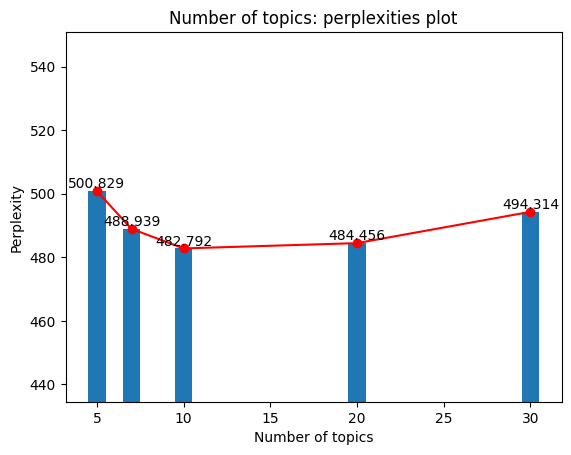

In [ ]:
perplexities = eval_lda_n_topics(
    random_state, X_train_cv, n_list=[5, 7, 10, 20, 30], width=1
)

LDA sur les données

In [ ]:
n_topics = 10

lda = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=random_state,
)

# topics for train data
lda.fit(X_train_cv)
n_top_words = 10
topics = get_topics(lda, cv_names, n_top_words)

# topics for test data
X_test_lda = lda.transform(X_test_cv)
top_topics_test = [xi.argsort()[:-2:-1][0] for xi in X_test_lda]

# <a id='toc2_'></a>[Score Jaccard](#toc0_)

Création d'un second score, qui correspond à une couverture des tags, mais plus sévère (le tag est exactement présent ou non).  
Ce score est le score Jaccard, une analyse de similarité d'ensembles, représentée ainsi : $$J(A, B) = \frac{|A ∩ B|}{|A ∪ B|}$$

Ce score nécessite une adaptation pour le cas présent puisqu'il prend nécessairement des données de même taille (prédictions et cibles) : pour être cohérent avec le score de couverture de tags précédemment utilisé et sachant que le nombre d'éléments entre cible et prédiction peut différer, il a été convenu d'utiliser en priorité les tags correctement trouvés par le modèle avant d'être complétés par les autres, dans la limite du nombre de tags de la cible.

# <a id='toc3_'></a>[Classification One vs Rest, régression logistique](#toc0_)

Les algorithmes de classification permettent d'effectuer des classifications probabilistes afin de déterminer l'appartenance d'un individu à telle ou telle classe.

La régression logistique fait partie de cette famille d'algorithmes, en étant un modèle discriminant (non génératif), mais prévu pour une classification binaire et non pour du multi-classe.  

La classification One vs Rest permet justement de décomposer une classification multi-classes en binaire, en entraînant un classificateur par classe à distringuer sa classe de toutes les autres.  
La classe assignée correspond au classificateur avec la probabilité d'appartenance la plus élevée.

[Article MachineLearning Mastery](https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/)

[Étude : Stratégie Multitâche pour la Classification Multiclasse](https://aclanthology.org/2021.jeptalnrecital-taln.22.pdf)

L'approche suivante par régression logistique est effectuée par vectorisation simple (comptage, sans word embedding).

In [ ]:
%%time
logreg = LogisticRegression(multi_class="ovr")
logreg.fit(X_train_cv, y_train)

/home/jl/projets/OC_P5_SoF/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


CPU times: user 2min 28s, sys: 171 ms, total: 2min 28s
Wall time: 2min 28s


LogisticRegression(multi_class='ovr')

In [ ]:
lr_preds_raw = logreg.predict(X_test_cv)

Exemple

In [ ]:
i = 4

print(f"data:\n\t{X_test.tolist()[i]}")
print(f"topic {top_topics_test[i]}:\n\t{topics[top_topics_test[i]]}")
print(f"pred:\n\t{lr_preds_raw[i]}")
print(f"target:\n\t{y_test.tolist()[i]}")

data:
	cross-site cookies set cookie backend frontend currently developing webapp frontend backend test jointly chrome frontend make correct api call backend display cookies apology advance long post going many resources past couple day point unsure relevant frontend backend proper settings cors believe backend situation frontend make request backend backend set cookie attempt set cookie backend make request frontend attempt tab chrome get warning network tab get message examining response header research come attempt set cookie backend make request frontend attempt tab chrome get exact warning attempt though response header additionally header warning try come attempt everything attempt except fetch get warning backend missing attempt surely must easy set cookie backend frontend worrying https choice locally backend server accessed research made seem complicated/time-consuming process fair understanding web-dev/all thing network limited
topic 8:
	api request get call spring message br

## <a id='toc3_1_'></a>[Nombre de tags prédits](#toc0_)

Il est possible que certaines prédictions soient nulles ou bien qu'elles ne renvoient pas les 5 tags souhaités

In [ ]:
print(f"5 tags: {len([p for p in lr_preds_raw if len(p.split(' ')) == 5])}")
print(f"4 tags: {len([p for p in lr_preds_raw if len(p.split(' ')) == 4])}")
print(f"3 tags: {len([p for p in lr_preds_raw if len(p.split(' ')) == 3])}")
print(f"2 tags: {len([p for p in lr_preds_raw if len(p.split(' ')) == 2])}")
print(f"1 only tag: {len([p for p in lr_preds_raw if len(p.split(' ')) == 1])}")
print(f"No tag: {len([p for p in lr_preds_raw if len(p.split(' ')) < 1])}")

5 tags: 512
4 tags: 317
3 tags: 111
2 tags: 53
1 only tag: 7
No tag: 0


Il est possible d'utiliser les prédictions pour obtenir directement les 5 tags souhaités

In [ ]:
def lr_predict_tags(model, X, n_tags=5) -> list:
    """Use logistic regression probabilities to get at least n predicted tags"""
    ppbs = model.predict_proba(X)
    classes = model.classes_
    pred_tags = []

    for i, x in enumerate(X):
        # create list of tags from n first classes
        pred_list = (
            (" ")
            .join([classes[c] for c in ppbs[i].argsort()[: -n_tags - 1 : -1]])
            .split(" ")
        )
        # keep only 5 first tags
        pred = set()
        j = 0
        while len(pred) < 5:
            pred.add(pred_list[j])
            j += 1
        # add tags to predictions list
        pred_tags.append((" ").join(pred))

    return pred_tags

Application sur les données de test

In [ ]:
lr_preds = lr_predict_tags(logreg, X_test_cv)

Exemple

In [ ]:
print(f"data:\n\t{X_test.tolist()[i]}")
print(f"topic {top_topics_test[i]}:\n\t{topics[top_topics_test[i]]}")
print(f"raw predictions:\n\t{lr_preds_raw[i]}")
print(f"target:\n\t{y_test.tolist()[i]}")
print(f"5 tags predictions:\n\t{lr_preds[i]}")

data:
	cross-site cookies set cookie backend frontend currently developing webapp frontend backend test jointly chrome frontend make correct api call backend display cookies apology advance long post going many resources past couple day point unsure relevant frontend backend proper settings cors believe backend situation frontend make request backend backend set cookie attempt set cookie backend make request frontend attempt tab chrome get warning network tab get message examining response header research come attempt set cookie backend make request frontend attempt tab chrome get exact warning attempt though response header additionally header warning try come attempt everything attempt except fetch get warning backend missing attempt surely must easy set cookie backend frontend worrying https choice locally backend server accessed research made seem complicated/time-consuming process fair understanding web-dev/all thing network limited
topic 8:
	api request get call spring message br

Résultats sur l'échantillon de test : prédictions basiques

Tag cover score: 0.227 - Jaccard score: 0.2 - Duration: 14.0


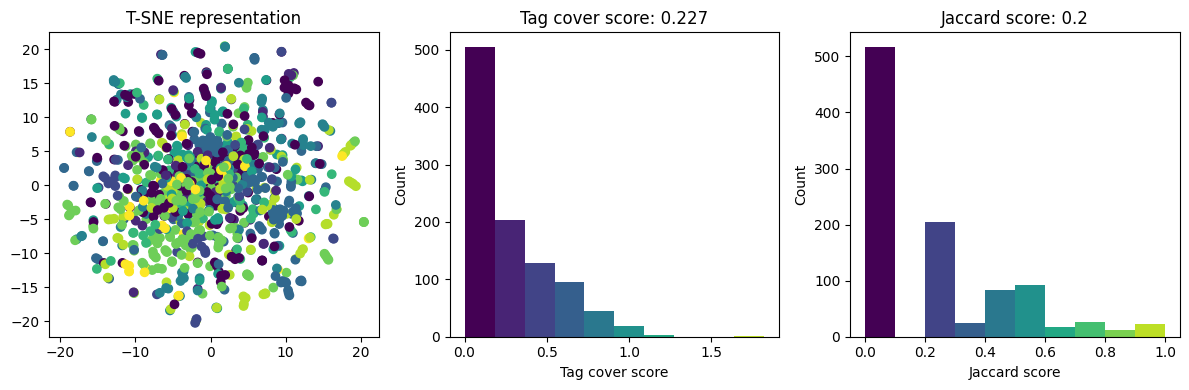

In [ ]:
lr_scores_raw = score_plot_model(
    lr_preds_raw, logreg.predict_proba(X_test_cv), y_test, top_topics=top_topics_test
)

Résultats sur l'échantillon de test : prédictions à 5 tags

Tag cover score: 0.258 - Jaccard score: 0.188 - Duration: 14.0


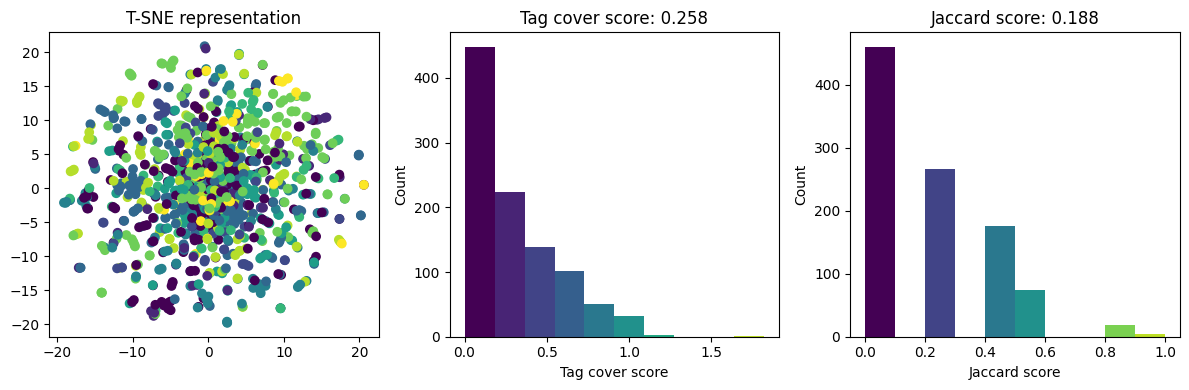

In [ ]:
lr_scores = score_plot_model(
    lr_preds, logreg.predict_proba(X_test_cv), y_test, top_topics=top_topics_test
)

Les scores ont mécaniquement évolué avec la prédiction systématique des 5 tags :
- le score de couverture des tags ne peut qu'augmenter avec davantage de prédictions
- le score Jaccard, plus strict et plafonné par le nombre de tags de la cible, est moins impacté

On constate aussi que dans de rares cas, certains scores de couverture de tags sont supérieurs à 1.  
Cela se produit seulement lorsqu'il y a peu de tags et que ceux-ci sont trouvés plusieurs fois par les prédictions.

Comme vu plus haut, le score de Jaccard n'est pas impacté par ce phénomène, ce qui explique partiellement la montée du score de couverture et la stagnation du score de Jaccard.

In [ ]:
i = 75

print(f"data:\n\t{X_test.tolist()[i]}")
print(f"topic {top_topics_test[i]}:\n\t{topics[top_topics_test[i]]}")
print(f"pred:\n\t{lr_preds[i]}")
print(f"target:\n\t{y_test.tolist()[i]}")
print(f"TC score:\n\t{lr_scores[2][i]}")
print(f"J score:\n\t{lr_scores[3][i]}")

data:
	angular this.formgroup.updatevalueandvalidity properly add remove validators controls based certain condition updating validators whole form updating specifically applying control i.e write control hope correct wrong
topic 3:
	test function component class c++ compiler object case call return
pred:
	angular angular-cli angular9 angular8 npm
target:
	angular typescript
TC score:
	1.822
J score:
	0.2


Outre les scores, on constate manuellement que les **prédictions sont souvent cohérentes** avec les données d'entrée.

# <a id='toc4_'></a>[Approche *word embedding*](#toc0_)

Le même traitement précédent est appliqué, seulement la vectorisation ne sera plus assurée par une approche bag-of-words comme CountVectorizer mais par des techniques différentes, appelées *word embedding* ou *sentence embedding*.

Ces techniques permettent de créer des vecteurs denses au lieu de grandes matrices vides qui écartent le contexte et le sens et dépendent seulement du corpus fourni.

## <a id='toc4_1_'></a>[Pré-traitement commun](#toc0_)

Résumé des traitements précédents, avec tokenisation supplémentaire pour certains modèles prenant en entrée une liste de mots plutôt qu'une chaîne de caractères

In [3]:
# get preprocessed data
df_pp = init_data()

# get max_length, useful for some models
max_length = max([len(x.split(" ")) for x in df_pp["doc_bow"].values])

# select from dates and split data
X_train, X_test, y_train, y_test = select_split_data(
    df_pp,
    random_state=42,
    test_size=1000,
    start_date="2019-05-01",
    end_date=None,
)

#  tokenized data
X_train_tok = X_train.str.split(" ")
X_test_tok = X_test.str.split(" ")

print(f"{X_train_tok.shape = }, {X_test_tok.shape = }")

INFO:root:✅ Preprocessed data loaded


X_train_tok.shape = (8999,), X_test_tok.shape = (1000,)


## <a id='toc4_2_'></a>[Pipeline d'évaluation](#toc0_)

Création d'un pipeline d'évaluation pour tester uniformément les modèles, disponible dans le script `src/models.py` et composé comme suit :

In [3]:
def evaluate_model(data, vocab=None, n_topics=5, random_state=42, plot=True) -> tuple:
    """Train ML model from preprocessed and splitted data, packed in a tuple"""
    start_time = time.time()

    # unpack data
    X_train_vect, X_test_vect, y_train, y_test = data

    # topic modeling for plot output
    if vocab is not None:
        n_top_words = 10
        lda = LatentDirichletAllocation(
            n_components=n_topics,
            max_iter=5,
            learning_method="online",
            learning_offset=50.0,
            random_state=random_state,
        )

        # LDA needs positive values
        X_train_pos = (
            X_train_vect + abs(X_train_vect.min())
            if X_train_vect.min() < 0
            else X_train_vect
        )
        X_test_pos = (
            X_test_vect + abs(X_test_vect.min())
            if X_test_vect.min() < 0
            else X_test_vect
        )

        # get topics
        lda.fit(X_train_pos)
        topics = get_topics(lda, vocab, n_top_words)
        X_test_lda = lda.transform(X_test_pos)
        top_topics_test = [xi.argsort()[:-2:-1][0] for xi in X_test_lda]
    else:
        top_topics_test = None

    # classify
    logging.info(f"Classifying...")
    logreg = LogisticRegression(multi_class="ovr")
    logreg.fit(X_train_vect, y_train)
    predicted_probas = logreg.predict_proba(X_test_vect)
    lr_preds = lr_predict_tags(logreg, X_test_vect)
    logging.info(f"✅ {len(lr_preds)} predictions done")

    # score
    logging.info(f"Scoring...")
    score_tc, score_j, scores_tc, scores_j = score_plot_model(
        lr_preds,
        predicted_probas,
        y_test,
        top_topics=top_topics_test,
        time_it=False,
        plot=plot,
    )

    # duration
    duration = np.round(time.time() - start_time, 0)
    logging.info(f"Total duration: {duration}")

    return score_tc, score_j, duration

## <a id='toc4_3_'></a>[Test avec CountVectorizer](#toc0_)

Vérification que les résultats sont équivalents

In [4]:
%%time

count_vectorizer = CountVectorizer(token_pattern=r"\S+", dtype=np.uint16, min_df=100)

X_train_cv = count_vectorizer.fit_transform(X_train)
X_test_cv = count_vectorizer.transform(X_test)
vocab_cv = count_vectorizer.get_feature_names_out()

CPU times: user 338 ms, sys: 6.35 ms, total: 344 ms
Wall time: 343 ms


INFO:root:Classifying...
/home/jl/projets/OC_P5_SoF/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
INFO:root:✅ 1000 predictions done
INFO:root:Scoring...


Tag cover score: 0.258 - Jaccard score: 0.188


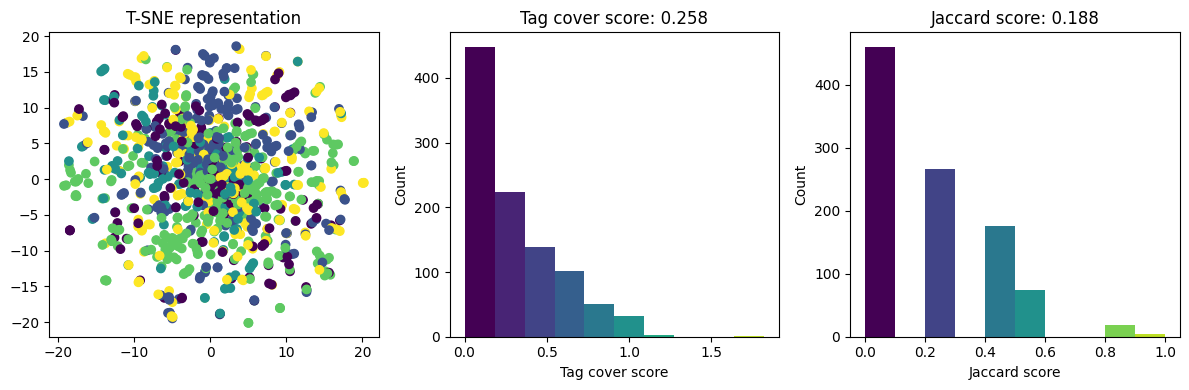

INFO:root:Total duration: 210.0


In [5]:
_ = evaluate_model((X_train_cv, X_test_cv, y_train, y_test), vocab=vocab_cv)

# <a id='toc5_'></a>[Word 2 Vec](#toc0_)

#### 🚧 expliquer modèle : cf. [cours OC](https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles/4855006-effectuez-des-plongements-de-mots-word-embeddings) et [❤️ ici](https://openclassrooms.com/fr/courses/6532301-introduction-to-natural-language-processing/8082110-discover-the-power-of-word-embeddings#/id/r-8081925)



In [6]:
%%time

w2v_vectorizer = Word2Vec(
    X_train_tok,  # train set only to avoid data leakage
    min_count=100,  # ignore words that appear less than this
    vector_size=50,  # dimensionality of word embeddings
    sg=1,  # skipgrams
    window=7,  # context window for words during training
    epochs=10,  # n epochs training over corpus
)

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 35474 word types from a corpus of 487937 raw words and 8999 sentences
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=100 retains 999 unique words (2.82% of original 35474, drops 34475)', 'datetime': '2024-06-05T15:55:53.409713', 'gensim': '4.3.2', 'python': '3.11.6 (main, Mar 19 2024, 19:27:13) [GCC 11.4.0]', 'platform': 'Linux-5.15.146.1-microsoft-standard-WSL2-x86_64-with-glibc2.35', 'event': 'prepare_vocab'}
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=100 leaves 317658 word corpus (65.10% of original 487937, drops 170279)', 'datetime': '2024-06-05T15:55:53.412635', 'gensim': '4.3.2', 'python': '3.11.6 (main, Mar 19 2024, 19:27:13) [GCC 11.4.0]', 'platform': 'Linux-5.15.146.1-micros

CPU times: user 26.9 s, sys: 97.5 ms, total: 27 s
Wall time: 9.56 s


Fonction de passage de la matrice W2V à une matrice numpy

In [7]:
def w2v_vect_data(model, matrix) -> np.array:
    """From a Word2Vec vectorizer, return a vectorized matrix"""
    # loop over rows in tokenized X_train
    doc_vectors = []
    for tokens in matrix:
        # loop over tokens in each row
        doc_vec = []
        for token in tokens:
            if token in model.wv:
                doc_vec.append(model.wv[token])
        # mean it
        doc_vectors.append(np.mean(doc_vec, axis=0))
    # get X_train matrix
    vector_matrix = np.array(doc_vectors)

    return vector_matrix

Vocabulaire

In [8]:
vocab_w2v = np.array(w2v_vectorizer.wv.index_to_key)
print(vocab_w2v.shape)
print(vocab_w2v[:20])

(999,)
['get' 'app' 'one' 'function' 'version' 'project' 'test' 'data' 'https'
 'class' 'time' 'set' 'make' 'type' 'user' 'build' 'api' 'find' 'solution'
 'image']


Vectorisation du set d'entraînement

In [9]:
X_train_w2v = w2v_vect_data(w2v_vectorizer, X_train_tok)
print(X_train_w2v.shape)
print(X_train_w2v[0])

(8999, 50)
[-0.30687353  0.10928044 -0.0060135  -0.03543865 -0.1480414  -0.32313585
  0.1481516   0.12151453 -0.3232747   0.08389871  0.06740093  0.22136845
  0.08142841 -0.09833743 -0.17311798  0.07677475  0.10573593 -0.03351645
  0.07291534 -0.13885583  0.10648894  0.16010365  0.14207287 -0.07863023
 -0.00163539  0.372694   -0.04223081 -0.17580497 -0.2913395   0.18920843
  0.18989214 -0.29550305  0.00696009 -0.10252219  0.27439117  0.02248274
  0.08316727  0.18468852  0.03457911 -0.08485197  0.22965908 -0.22917664
 -0.23371166  0.33396763  0.37526515 -0.00265093 -0.05768707 -0.4722108
  0.1183899  -0.3032031 ]


Vectorisation du set de tests

In [10]:
X_test_w2v = w2v_vect_data(w2v_vectorizer, X_test_tok)
print(X_test_w2v.shape)
print(X_test_w2v[0])

(1000, 50)
[-0.08558833  0.00726828  0.21273541  0.04661864  0.09106764 -0.25958586
 -0.03632931  0.40765765 -0.38992485 -0.17964976  0.2759385   0.22433536
  0.4642367   0.18282561  0.06154496 -0.11928692  0.38850084 -0.2887261
  0.3647635  -0.40621606  0.18652076  0.13287814 -0.03823886 -0.405952
 -0.12273389  0.5457168  -0.21293151  0.18668537 -0.19696061  0.30100152
  0.26969433  0.14865069 -0.21316122  0.12410644  0.16875745 -0.1341574
 -0.10318897  0.2985748   0.08009627  0.16816913  0.12755553 -0.39136696
 -0.04178217  0.3711653   0.37985227  0.03768895 -0.27430055 -0.33093458
  0.1722454   0.07098502]


Predictions de tags individuels

In [11]:
# Function to predict tags
def predict_tags_(model, sentence, top_n=5):
    tokenized_sentence = sentence.split(" ")
    valid_tokens = [token for token in tokenized_sentence if token in model.wv]

    if valid_tokens:
        tags = model.wv.most_similar(positive=valid_tokens, topn=top_n)
        return [tag[0] for tag in tags]
    else:
        return []


# EXAMPLE
i = 5344
input_sentence = X_test[i]
target = y_test[i]

w2v_predict_tags = predict_tags_(w2v_vectorizer, input_sentence)
print(f"Sentence\n\t'{input_sentence}")
print(f"Prediction\n\t{w2v_predict_tags}")
print(f"Target\n\t{target}")

Sentence
	'getapplicationdocumentsdirectory flutter desktop windows save open flutter desktop windows getapplicationdocumentsdirectory flutter desktop windows throw
Prediction
	['wsl', 'computer', 'studio', 'terminal', 'normal']
Target
	android windows flutter dart


Évaluation du modèle

INFO:root:Classifying...
/home/jl/projets/OC_P5_SoF/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
INFO:root:✅ 1000 predictions done
INFO:root:Scoring...


Tag cover score: 0.156 - Jaccard score: 0.124


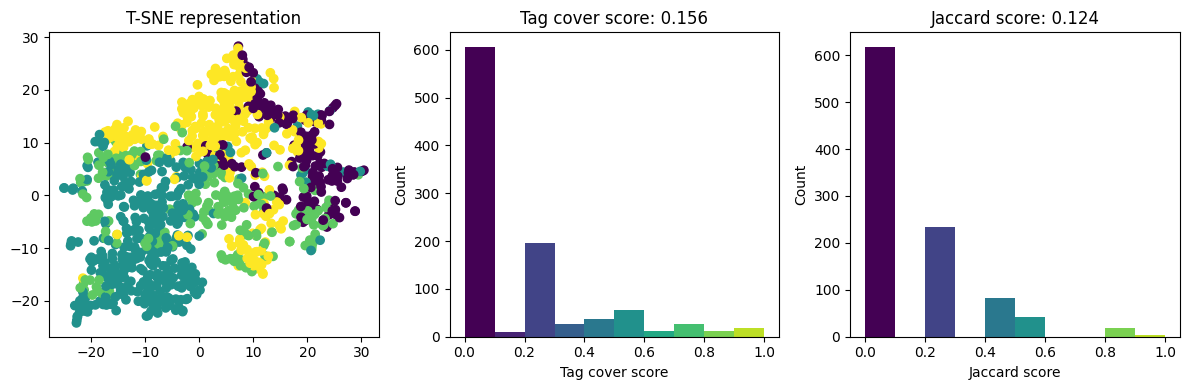

INFO:root:Total duration: 244.0


In [12]:
_ = evaluate_model((X_train_w2v, X_test_w2v, y_train, y_test), vocab=vocab_w2v)

# <a id='toc6_'></a>[USE (Universal Sentence Encoder)](#toc0_)

#### 🚧 expliquer modèle, cf. [ici](https://www.kaggle.com/models/google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder)

In [ ]:
%%time

tfuse_vectorizer = hub.load(
    "https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2"
)

X_train_tfuse = tfuse_vectorizer(X_train)
X_test_tfuse = tfuse_vectorizer(X_test)

print(X_train_tfuse.shape)
print(X_test_tfuse.shape)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Fingerprint not found. Saved model loading will continue.
INFO:absl:path_and_singleprint metric could not be logged. Saved model loading will continue.
2024-05-31 13:08:22.660950: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


(8999, 512)
(1000, 512)
CPU times: user 12.6 s, sys: 4.63 s, total: 17.3 s
Wall time: 13.8 s


### Vocabulaire absent

Avec ce modèle pré-entraîné, il n'est pas possible de :
- l'entraîner à nouveau sur des données personnalisées
- limiter la vectorisation à des mots suffisamment présents
- récupérer le vocabulaire de la vectorisation

Le vocabulaire utilisé n'étant pas accessible (cf. [papier original](https://aclanthology.org/D18-2029/) et [problème soulevé sur GitHub](https://github.com/tensorflow/hub/issues/67)), il n'est pas possible de le passer dans un modèle de topic type LDA (utilisé dans la fonction d'évaluation ci-après).

Évaluation du modèle

INFO:root:Classifying...
/home/jl/projets/OC_P5_SoF/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
INFO:root:✅ 1000 predictions done
INFO:root:Scoring...


Tag cover score: 0.071 - Jaccard score: 0.06


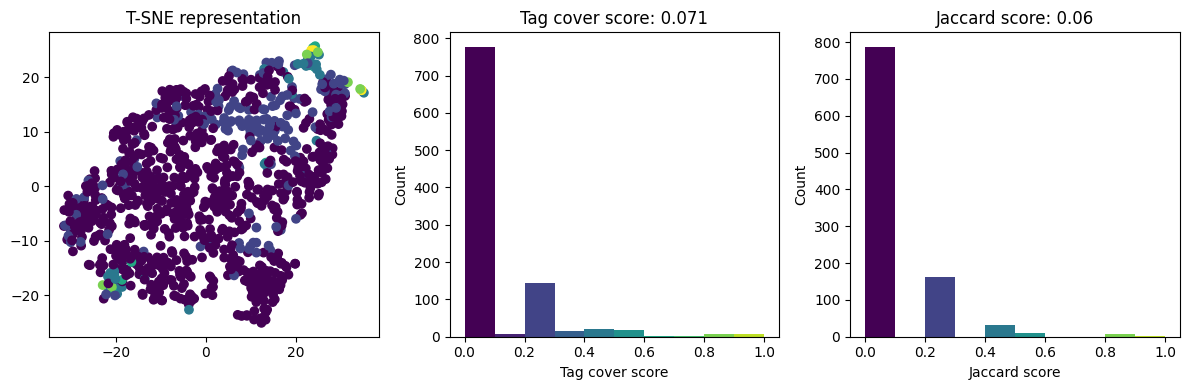

INFO:root:Total duration: 682.0


In [ ]:
_ = evaluate_model((X_train_tfuse, X_test_tfuse, y_train, y_test))

# <a id='toc7_'></a>[BERT (Bidirectional Encoder Representations from Transformers)](#toc0_)

#### 🚧 expliquer modèle, cf. [papier original](https://arxiv.org/abs/1810.04805) et [documentation HF](https://huggingface.co/docs/transformers/main/en/model_doc/bert) et [❤️ classification avec BERT](https://www.tensorflow.org/text/tutorials/classify_text_with_bert?hl=fr)

dire qu'on n'utilise que la fonction de word embedding de BERT : pas adapté, il faudrait pré-entraîner sur des données moins pré-processées, davantage sur le langage humain

#### 🚧 choix modèle : dire q pré-entraîné sur 152 million de phrases de Stack Overflow depuis sur une archive de 10 ans

[modèle pré-entraîné SoF lanwuwei](https://huggingface.co/lanwuwei/BERTOverflow_stackoverflow_github) - [papier ici](https://aclanthology.org/2020.acl-main.443/)

Based on the information provided in the search results, the parameters padding=True, truncation=True, and add_special_tokens=True are used in BERT tokenizers to control how the input text is preprocessed before being fed into the BERT model.

padding=True:  
This parameter is used to ensure that all sequences in a batch have the same length by padding shorter sequences with a special pad_token (usually [PAD]). This is necessary because BERT models expect inputs of fixed length during training and inference.  
When padding=True, the tokenizer will pad all sequences in the batch to the length of the longest sequence. The max_length parameter can also be specified to set a maximum length for padding.

truncation=True:  
This parameter is used to truncate sequences that are longer than the specified max_length. When truncation=True, sequences longer than max_length will be truncated (cut off) to the max_length.  
Truncation is often used in combination with padding to ensure all sequences have the same length required by the model.

add_special_tokens=True:  
BERT models expect certain special tokens like [CLS] (classification token) and [SEP] (separator token) to be added to the input sequences. Setting add_special_tokens=True ensures that these special tokens are added appropriately during tokenization.  
For example, for sequence classification tasks, the [CLS] token is added at the beginning, and the [SEP] token is added at the end of the sequence.

By setting these parameters correctly during tokenization, the input data is preprocessed and formatted in a way that is compatible with the BERT model's expectations. This allows the model to process the input sequences effectively during training and inference.

**MAIS**

malgré pré-entraînement, pré-traitement pas bon pour BERT : trop sélectif / peu humain => amélioration = refaire pré-traitement + adapté à ce modèle (bien moindre)  

Le modèle nécessite des ressources que le noyau Jupyter ne peut pas assurer, des limites sont ainsi fixées :
- taille d'échantillon (*batch*)
- longueur des vecteurs représentant chaque individu
- nombre d'individus analysés

In [ ]:
batch_size = 10  # to avoid Jupyter kernel explosion
max_length = 32  # for stable tensors size
max_pop = 200  # max population to process

In [ ]:
%%time

from transformers import AutoTokenizer
from transformers import TFAutoModel
from transformers import AutoModelForTokenClassification
from transformers import TFAutoModelForTokenClassification
from transformers import pipeline

model_name = "lanwuwei/BERTOverflow_stackoverflow_github"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

/home/jl/projets/OC_P5_SoF/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForTokenClassification were not initialized from the model checkpoint at lanwuwei/BERTOverflow_stackoverflow_github and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CPU times: user 1.32 s, sys: 474 ms, total: 1.8 s
Wall time: 3.02 s


Vocabulaire

In [ ]:
vocab_bert = tokenizer.get_vocab()

In [ ]:
len(vocab_bert)

82000

Vectorisation : word embedding

In [ ]:
%%time

X_train_bert_pt = bert_w_emb(
    model,
    tokenizer,
    X_train.tolist(),
    batch_size=batch_size,
    max_length=max_length,
    max_pop=max_pop,
)

INFO:root:Step 0 ok on data[0:10] -> shape torch.Size([10, 32, 55])
INFO:root:Step 1 ok on data[10:20] -> shape torch.Size([20, 32, 55])
INFO:root:Step 2 ok on data[20:30] -> shape torch.Size([30, 32, 55])
INFO:root:Step 3 ok on data[30:40] -> shape torch.Size([40, 32, 55])
INFO:root:Step 4 ok on data[40:50] -> shape torch.Size([50, 32, 55])
INFO:root:Step 5 ok on data[50:60] -> shape torch.Size([60, 32, 55])
INFO:root:Step 6 ok on data[60:70] -> shape torch.Size([70, 32, 55])
INFO:root:Step 7 ok on data[70:80] -> shape torch.Size([80, 32, 55])
INFO:root:Step 8 ok on data[80:90] -> shape torch.Size([90, 32, 55])
INFO:root:Step 9 ok on data[90:100] -> shape torch.Size([100, 32, 55])
INFO:root:Step 10 ok on data[100:110] -> shape torch.Size([110, 32, 55])
INFO:root:Step 11 ok on data[110:120] -> shape torch.Size([120, 32, 55])
INFO:root:Step 12 ok on data[120:130] -> shape torch.Size([130, 32, 55])
INFO:root:Step 13 ok on data[130:140] -> shape torch.Size([140, 32, 55])
INFO:root:Step 14

CPU times: user 18.7 s, sys: 486 ms, total: 19.1 s
Wall time: 9.94 s


In [ ]:
%%time

X_test_bert_pt = bert_w_emb(
    model,
    tokenizer,
    X_test.tolist(),
    batch_size=batch_size,
    max_length=max_length,
    max_pop=max_pop,
)

INFO:root:Step 0 ok on data[0:10] -> shape torch.Size([10, 32, 55])
INFO:root:Step 1 ok on data[10:20] -> shape torch.Size([20, 32, 55])
INFO:root:Step 2 ok on data[20:30] -> shape torch.Size([30, 32, 55])
INFO:root:Step 3 ok on data[30:40] -> shape torch.Size([40, 32, 55])
INFO:root:Step 4 ok on data[40:50] -> shape torch.Size([50, 32, 55])
INFO:root:Step 5 ok on data[50:60] -> shape torch.Size([60, 32, 55])
INFO:root:Step 6 ok on data[60:70] -> shape torch.Size([70, 32, 55])
INFO:root:Step 7 ok on data[70:80] -> shape torch.Size([80, 32, 55])
INFO:root:Step 8 ok on data[80:90] -> shape torch.Size([90, 32, 55])
INFO:root:Step 9 ok on data[90:100] -> shape torch.Size([100, 32, 55])
INFO:root:Step 10 ok on data[100:110] -> shape torch.Size([110, 32, 55])
INFO:root:Step 11 ok on data[110:120] -> shape torch.Size([120, 32, 55])
INFO:root:Step 12 ok on data[120:130] -> shape torch.Size([130, 32, 55])
INFO:root:Step 13 ok on data[130:140] -> shape torch.Size([140, 32, 55])
INFO:root:Step 14

CPU times: user 27.4 s, sys: 24.8 s, total: 52.3 s
Wall time: 28.4 s


Réduction des tenseurs à 2 dimensions pour l'évaluation

In [ ]:
# train
X_train_bert_np = X_train_bert_pt.detach().numpy()
X_train_bert = np.reshape(X_train_bert_np, (len(X_train_bert_np), max_length * 55))
print(f"{X_train_bert.shape = }")

# test
X_test_bert_np = X_test_bert_pt.detach().numpy()
X_test_bert = np.reshape(X_test_bert_np, (len(X_test_bert_np), max_length * 55))
print(f"{X_test_bert.shape = }")

X_train_bert.shape = (200, 1760)
X_test_bert.shape = (200, 1760)


INFO:root:Classifying...
/home/jl/projets/OC_P5_SoF/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
INFO:root:✅ 200 predictions done
INFO:root:Scoring...


Tag cover score: 0.08 - Jaccard score: 0.055


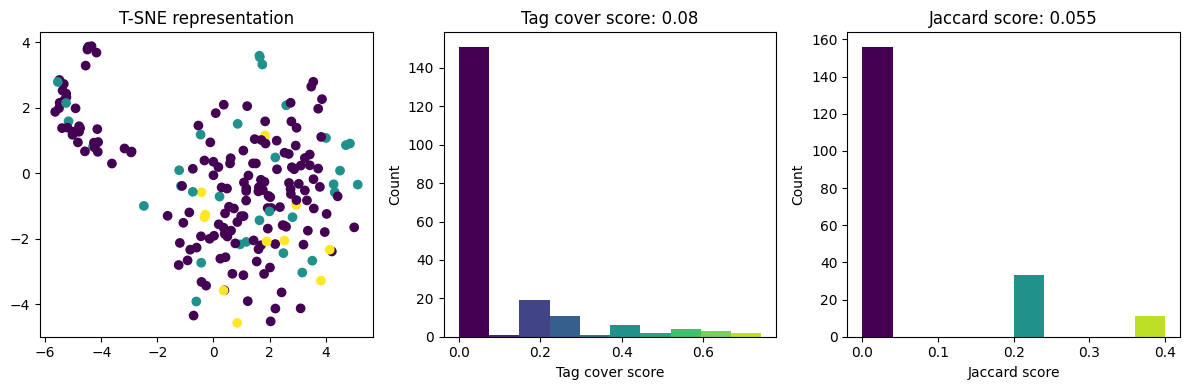

INFO:root:Total duration: 10.0


In [ ]:
_ = evaluate_model((X_train_bert, X_test_bert, y_train[:max_pop], y_test[:max_pop]))

# <a id='toc8_'></a>[Stabilité](#toc0_)

## <a id='toc8_1_'></a>[Méthodologie et, améliorations](#toc0_)

Évaluation de la stabilité du modèle dans le temps :
- entraînement sur **plusieurs années de données** pour obtenir une **population d'environ 10000** (la régression logistique prend trop de temps au-delà)
- **fenêtre glissante pour évaluation mois par mois** sur les mois suivant les dates d'entraînement

Le modèle de vectorisation choisi est **Word2Vec** car il s'agit d'un word embedder simple, fonctionnel et demandant relativement peu de ressources.

Le reste du **pipeline ainsi que la méthode d'évaluation sont identiques** à ce qui a été fait précédemment.

La fonction d'évaluation `eval_stability()` diffère cependant car elle prend en compte le fait qu'il s'agit d'une boucle sur les tests et **évite de multiplier les entraînements** et se passe des graphiques.

L'entraînement est bien séparé de l'inférence.

## Jeux de données

Date la plus récente

In [3]:
last_date = df_pp.sort_values(by=["date"], ascending=False)["date"][0]
last_date

'2024-03-14 22:55:18'

Choix d'un jeu de données d'entraînement d'environ 10000 individus, avec 1 an de recul pour vérifier la stabilité mois par mois

In [3]:
# set start / end dates
start_date = "2019-03-01"
end_date = "2023-03-01"

# ceil / floor data from date
df_train = df_pp.loc[
    (df_pp["date"] >= start_date) & (df_pp["date"] < end_date), ["doc_bow", "tags"]
]
X_train = df_train["doc_bow"].str.split(" ")
y_train = df_train["tags"]

print(f"{X_train.shape = }, {y_train.shape = }")

X_train.shape = (10615,), y_train.shape = (10615,)


Échantillonnage pour tests de stabilité

In [5]:
# set start / end dates for each sample
end_dates = [
    "2023-03-01",
    "2023-04-01",
    "2023-05-01",
    "2023-06-01",
    "2023-07-01",
    "2023-08-01",
    "2023-09-01",
    "2023-10-01",
    "2023-11-01",
    "2023-12-01",
    "2024-01-01",
    "2024-02-01",
    "2024-03-01",
]

X_test_list = []
y_test_list = []

for i, end_date in enumerate(end_dates[1:]):
    start_date = end_dates[i]
    df_test = df_pp.loc[
        (df_pp["date"] >= start_date) & (df_pp["date"] < end_date), ["doc_bow", "tags"]
    ]
    X_ = df_test["doc_bow"].str.split(" ")
    y_ = df_test["tags"]
    y_test_list.append(y_)
    X_test_list.append(X_)
    print(
        f"Step {i+1}: start {start_date}, end {end_date}, X shape {X_.shape}, y shape {y_.shape}"
    )

Step 1: start 2023-03-01, end 2023-04-01, X shape (32,), y shape (32,)
Step 2: start 2023-04-01, end 2023-05-01, X shape (24,), y shape (24,)
Step 3: start 2023-05-01, end 2023-06-01, X shape (23,), y shape (23,)
Step 4: start 2023-06-01, end 2023-07-01, X shape (26,), y shape (26,)
Step 5: start 2023-07-01, end 2023-08-01, X shape (26,), y shape (26,)
Step 6: start 2023-08-01, end 2023-09-01, X shape (27,), y shape (27,)
Step 7: start 2023-09-01, end 2023-10-01, X shape (18,), y shape (18,)
Step 8: start 2023-10-01, end 2023-11-01, X shape (11,), y shape (11,)
Step 9: start 2023-11-01, end 2023-12-01, X shape (17,), y shape (17,)
Step 10: start 2023-12-01, end 2024-01-01, X shape (8,), y shape (8,)
Step 11: start 2024-01-01, end 2024-02-01, X shape (7,), y shape (7,)
Step 12: start 2024-02-01, end 2024-03-01, X shape (3,), y shape (3,)


Vérification des données

In [6]:
i = 11
j = -1
print(f"{len(X_test_list[i]) = }, {len(y_test_list[i]) = }")
print(X_test_list[i].to_list()[j])
print(y_test_list[i].to_list()[j])

len(X_test_list[i]) = 3, len(y_test_list[i]) = 3
['keyword', 'false', 'integer', 'constant', 'expression', 'gcc', 'c23', 'latest', 'gcc', 'trunk', 'give', 'compiler', 'incompatible', 'types', 'initializing', 'type', 'type', 'correct', 'c23', 'types', 'definition', 'integer', 'types', 'type', 'unsigned', 'integer', 'types', 'correspond', 'standard', 'signed', 'integer', 'types', 'standard', 'unsigned', 'integer', 'types', 'standard', 'signed', 'integer', 'types', 'standard', 'unsigned', 'integer', 'types', 'collectively', 'called', 'standard', 'integer', 'types', 'c23', 'constant', 'expression', 'definition', 'integer', 'constant', 'expression', 'integer', 'constant', 'expression', 'shall', 'integer', 'type', 'c23', 'pointers', 'definition', 'null', 'pointer', 'constant', 'integer', 'constant', 'expression', 'expression', 'cast', 'type', 'predefined', 'constant', 'called', 'null', 'pointer', 'constant', 'c23', 'simple', 'assignment', 'constraints', 'left', 'operand', 'atomic', 'qualifie

## Entraînement

In [4]:
%%time

w2v_vectorizer = Word2Vec(
    X_train,  # train set only to avoid data leakage
    min_count=100,  # ignore words that appear less than this
    vector_size=50,  # dimensionality of word embeddings
    sg=1,  # skipgrams
    window=7,  # context window for words during training
    epochs=10,  # n epochs training over corpus
)

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 538006 words, keeping 38017 word types
INFO:gensim.models.word2vec:collected 39625 word types from a corpus of 572372 raw words and 10615 sentences
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=100 retains 1133 unique words (2.86% of original 39625, drops 38492)', 'datetime': '2024-06-07T09:33:51.113204', 'gensim': '4.3.2', 'python': '3.11.6 (main, Mar 19 2024, 19:27:13) [GCC 11.4.0]', 'platform': 'Linux-5.15.146.1-microsoft-standard-WSL2-x86_64-with-glibc2.35', 'event': 'prepare_vocab'}
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=100 leaves 387536 word corpus (67.71% of original 572372, drops 184836)', 'datetime': '2024-06-07T09:33:51.114239', 'gensim':

CPU times: user 24 s, sys: 41 ms, total: 24.1 s
Wall time: 8.34 s


Vocabulaire

In [8]:
vocab_w2v = np.array(w2v_vectorizer.wv.index_to_key)
print(vocab_w2v.shape)
print(vocab_w2v[:20])

(1133,)
['get' 'app' 'function' 'one' 'project' 'version' 'test' 'data' 'https'
 'class' 'time' 'set' 'make' 'user' 'build' 'type' 'api' 'find' 'image'
 'solution']


Vectorisation du set d'entraînement

In [9]:
%%time

X_train_w2v = w2v_vect_data(w2v_vectorizer, X_train)
print(X_train_w2v.shape)

(10615, 50)
CPU times: user 740 ms, sys: 45 µs, total: 741 ms
Wall time: 740 ms


Entraînement de la régression logistique

In [10]:
%%time

# train classifier
logging.info(f"⚙️ Training classifier...")
logreg = LogisticRegression(multi_class="ovr")
logreg.fit(X_train_w2v, y_train)
logging.info(f"✅ Training done")

INFO:root:⚙️ Training classifier...
/home/jl/projets/OC_P5_SoF/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
INFO:root:✅ Training done


CPU times: user 6min 49s, sys: 6min 51s, total: 13min 40s
Wall time: 3min 27s


## Tests du modèle

Vectorisation des sets de tests

In [11]:
X_test_list_w2v = []
for i in X_test_list:
    X_test_w2v = w2v_vect_data(w2v_vectorizer, i)
    X_test_list_w2v.append(X_test_w2v)

# check processing
print(X_test_list_w2v[11].shape)

(3, 50)


Évaluation des modèles en fonction du temps

In [12]:
# output:
# lr_predictions, lr_probas, tag_cover_scores, jaccard_scores, duration
stability_results = eval_stability(logreg, X_test_list_w2v, y_test_list)

INFO:root:⚙️ Step 1: 32 predictions
INFO:root:	➡️ tag cover 0.131, Jaccard 0.088

INFO:root:⚙️ Step 2: 24 predictions
INFO:root:	➡️ tag cover 0.16, Jaccard 0.142

INFO:root:⚙️ Step 3: 23 predictions
INFO:root:	➡️ tag cover 0.162, Jaccard 0.096

INFO:root:⚙️ Step 4: 26 predictions
INFO:root:	➡️ tag cover 0.167, Jaccard 0.131

INFO:root:⚙️ Step 5: 26 predictions
INFO:root:	➡️ tag cover 0.249, Jaccard 0.146

INFO:root:⚙️ Step 6: 27 predictions
INFO:root:	➡️ tag cover 0.14, Jaccard 0.096

INFO:root:⚙️ Step 7: 18 predictions
INFO:root:	➡️ tag cover 0.18, Jaccard 0.1

INFO:root:⚙️ Step 8: 11 predictions
INFO:root:	➡️ tag cover 0.151, Jaccard 0.091

INFO:root:⚙️ Step 9: 17 predictions
INFO:root:	➡️ tag cover 0.19, Jaccard 0.106

INFO:root:⚙️ Step 10: 8 predictions
INFO:root:	➡️ tag cover 0.177, Jaccard 0.1

INFO:root:⚙️ Step 11: 7 predictions
INFO:root:	➡️ tag cover 0.179, Jaccard 0.143

INFO:root:⚙️ Step 12: 3 predictions
INFO:root:	➡️ tag cover 0.356, Jaccard 0.267

INFO:root:⏱️ Total durat

Visualisation des métriques

In [13]:
monthes = [d[:-3] for d in end_dates[:-1]]

plot_stability(
    monthes,
    stability_results["tag_cover_scores"],
    stability_results["jaccard_scores"],
    X_title="month",
    y_1_title="Tags cover score",
    y_2_title="Jaccard score"
)

Le modèle ne chute pas après plusieurs mois, il y a plusieurs raisons potentielles à cela :
- la **population des échantillons de test est souvent trop faible** pour que le test soit représentatif (32, 24, 23, 26, 26, 27, 18, 11, 17, 8, 7 et 3 : plus la question est récente, moins elle a un score élevé or ce score est un des critères d'entrée dans le jeu de données)
- il peut y avoir une certaine **inertie dans la nature des problématiques StackOverFlow**, 1 an serait ainsi peut-être trop court pour voir une chute de stabilité
- le **pré-traitement peut être trop sélectif** et lisserait la nature des échanges

## Test avec des échantillons plus importants

Utilisation de l'API dans des conditions hors RGPD (pas d'information personnelle, cf. [notebook dédié](./2_stackapi_trial.ipynb))

In [14]:
from stackapi import StackAPI


def get_data_from_API(start_date_str, end_date_str) -> pd.DataFrame:
    """Get 100 raw questions from API (no personal info)"""
    SITE = StackAPI("stackoverflow")
    SITE.page_size = 100
    SITE.max_pages = 1

    response = SITE.fetch(
        "questions",
        # adds a filter to the request to only get the fields we need
        filter="!-.GgdhmLEqVItggCo)3Be_X2",
        # only get questions from date
        fromdate=int(pd.Timestamp(start_date_str).timestamp()),
        # to date
        todate=int(pd.Timestamp(end_date_str).timestamp()) - 1,
        # sorted by votes
        sort="votes",
    )

    print(f"🔎 {len(response['items'])} questions found")

    # create dataframe
    df = pd.DataFrame(response["items"])
    df["creation_date"] = pd.to_datetime(df["creation_date"], unit="s")
    df = df[["title", "body", "tags"]]

    return df, response

Visualisation d'un échantillon

In [15]:
df_raw_ = get_data_from_API("2023-03-01", "2023-04-01")[0]

🔎 100 questions found


In [16]:
df_raw_

,title,body,tags
0,Why are connections to GitHub over SSH throwin...,<p>Just sometime ago I started getting this wa...,"[git, github, ssh, ssh-keys]"
1,How do I solve &quot;error: externally-managed...,<p>Error message:</p>\n<blockquote>\n<pre clas...,"[python, error-handling, pip]"
2,OpenAI API error 429: &quot;You exceeded your ...,<p>I'm making a Python script to use OpenAI vi...,"[python, prompt, openai-api, completion, chatg..."
3,pip install -r requirements.txt is failing: &q...,"<p>Command:</p>\n<pre class=""lang-none prettyp...","[python, linux]"
4,Use of bitwise &#39;|&#39; with boolean operan...,<p>Just updated my Xcode to Version 14.3 today...,"[ios, xcode, react-native, xcode14]"
...,...,...,...
95,Flutter app crashes on /lib/arm64 - couldn&#39...,<p>I recently released my application on the P...,"[android, flutter, crashlytics]"
96,How can I solve the issue of &#39;failed to re...,<p>This is the error I got. There is a problem...,"[javascript, typescript, vue.js, vite, vitest]"
97,How to import JavaScript files in NodeJS using...,<h2>Question:</h2>\n<p>How to import JavaScrip...,"[javascript, node.js, webstorm, require, commo..."
98,InvalidOperationException: The view &#39;Index...,<p>The following error occurs when creating a ...,"[.net-core, asp.net-core-mvc]"


Pré-traitement des données

In [17]:
# load configuration
with open("config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

PROG_LANG = set(cfg["prog_languages"])
SPEC_TERMS = set(cfg["specific_terms"])
PUNCTUATION = set(cfg["punctuation"])
EXCLUDED_TERMS = set(cfg["excluded_terms"])

# kept tokens set
keep_set = PROG_LANG | SPEC_TERMS
# add tags from train set
y_train.apply(lambda x: keep_set.update(set(x.split(" "))))

# excluded tokens set
nltk.download("stopwords")  # downloaded just once, either checks update
stopwords = set(nltk.corpus.stopwords.words("english"))
exclude_set = PUNCTUATION | EXCLUDED_TERMS | stopwords

[nltk_data] Downloading package stopwords to /home/jl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Boucle sur les dates pour pré-traitement et échantillonnage X_test, y_test

In [ ]:
X_test_list = []
y_test_list = []

if os.path.exists("data/data_test_list.pkl"):
    with open("data/data_test_list.pkl", "rb") as f:
        data_test_list = pickle.load(f)
    X_test_list = data_test_list[0]
    y_test_list = data_test_list[1]
    logging.info("✅ Data loaded")

else:
    # TIP: can sometimes be refused by API, wait a few minutes and reload cell
    for i, end_date in enumerate(end_dates[1:]):
        start_date = end_dates[i]

        # get data for selected start / end dates
        response = get_data_from_API(start_date, end_date)
        backoff = response[1]["backoff"]
        df_ = response[0]

        # PREPROCESSING
        # add tags from test
        df_["tags"].apply(lambda x: keep_set.update(set(x)))
        # string cleaning
        df_["title_bow"] = df_["title"].apply(
            lambda x: preprocess_doc(x, keep_set, exclude_set)
        )
        df_["body_bow"] = df_["body"].apply(
            lambda x: preprocess_doc(x, keep_set, exclude_set)
        )
        # remove empty rows
        df_ = df_.loc[
            (df_["title_bow"].apply(lambda x: x.strip() != ""))
            | (df_["body_bow"].apply(lambda x: x.strip() != "")),
        ]
        # document
        df_["doc_bow"] = df_["title_bow"] + " " + df_["body_bow"]
        # tags
        df_["tags"] = df_["tags"].apply(lambda x: str.join(" ", x))
        df_pp = df_[["doc_bow", "tags"]]

        # store X, y
        X_ = df_["doc_bow"].str.split(" ")
        y_ = df_["tags"]
        X_test_list.append(X_)
        y_test_list.append(y_)

        print(
            f"Step {i+1}: start {start_date}, end {end_date}, X shape {X_.shape}, y shape {y_.shape}"
        )

        # wait before new API call
        time.sleep(20)

    # save data
    data_test_list = (X_test_list, y_test_list)
    with open("data/data_test_list.pkl", "wb") as f:
        pickle.dump(data_test_list, f)
    logging.info("✅ Data saved")

INFO:root:✅ Data loaded


Vectorisation des nouveaux sets de tests

In [26]:
X_test_list_w2v = []
for i in X_test_list:
    X_test_w2v = w2v_vect_data(w2v_vectorizer, i)
    X_test_list_w2v.append(X_test_w2v)

# check processing
print(X_test_list_w2v[11].shape)

(100, 50)


Évaluation du modèle sur ces nouvelles données

In [27]:
# output:
# lr_predictions, lr_probas, tag_cover_scores, jaccard_scores, duration
stability_results = eval_stability(logreg, X_test_list_w2v, y_test_list)

INFO:root:⚙️ Step 1: 100 predictions
INFO:root:	➡️ tag cover 0.117, Jaccard 0.07

INFO:root:⚙️ Step 2: 100 predictions
INFO:root:	➡️ tag cover 0.149, Jaccard 0.096

INFO:root:⚙️ Step 3: 100 predictions
INFO:root:	➡️ tag cover 0.124, Jaccard 0.082

INFO:root:⚙️ Step 4: 100 predictions
INFO:root:	➡️ tag cover 0.151, Jaccard 0.082

INFO:root:⚙️ Step 5: 100 predictions
INFO:root:	➡️ tag cover 0.202, Jaccard 0.104

INFO:root:⚙️ Step 6: 100 predictions
INFO:root:	➡️ tag cover 0.125, Jaccard 0.08

INFO:root:⚙️ Step 7: 100 predictions
INFO:root:	➡️ tag cover 0.151, Jaccard 0.072

INFO:root:⚙️ Step 8: 100 predictions
INFO:root:	➡️ tag cover 0.225, Jaccard 0.116

INFO:root:⚙️ Step 9: 100 predictions
INFO:root:	➡️ tag cover 0.14, Jaccard 0.084

INFO:root:⚙️ Step 10: 100 predictions
INFO:root:	➡️ tag cover 0.134, Jaccard 0.074

INFO:root:⚙️ Step 11: 100 predictions
INFO:root:	➡️ tag cover 0.1, Jaccard 0.064

INFO:root:⚙️ Step 12: 100 predictions
INFO:root:	➡️ tag cover 0.135, Jaccard 0.082

INFO:r

Visualisation de la stabilité

In [28]:
plot_stability(
    monthes,
    stability_results["tag_cover_scores"],
    stability_results["jaccard_scores"],
    X_title="month",
    y_1_title="Tags cover score",
    y_2_title="Jaccard score"
)

Comme précédemment, le modèle ne montre **pas de chute franche**, mais cette fois une **légère décroissance** à compter du 9ème mois après entraînement.

# Suivi MLFlow

#### 🚧 mettre code du pipe complet avec enregistrements MLFlow

dire q résumé des traitements : entraînement ET inférences (API-ready)

résultats visibles en lançant le serveur MLFlow via la commande `mlflow ui` dans un terminal dans l'environnement local, puis en allant sur [localhost:5000](http://127.0.0.1:5000)



Formalisation avec MLFlow d’expérimentations et de leur tracking, pour comparaison des performances des modèles
Stockage des modèles dans le “model registry” de MLFlow

mlflow.log_input(mlflow.data.from_pandas(X_train.to_frame(), source="data/mlfl_X_train.pkl"), context="training")
mlflow.log_input(mlflow.data.from_pandas(y_train.to_frame(), source="data/mlfl_y_train.pkl"), context="training")

mlflow.log_params({
    "w2v_min_count": w2v_min_count,
    "w2v_vector_size": w2v_vector_size,
    "w2v_sg": w2v_sg,
    "w2v_window": w2v_window,
    "w2v_epochs": w2v_epochs,
    "lr_multi_class": lr_multi_class,
})

mlflow.sklearn.log_model(logreg, "w2v_lr_ovr_model")


TEST

mlflow.log_artifact("data/data_test_list.pkl")
mlflow.log_metric("duration", stability_results["duration"])
boucle :
    mlflow.log_metric("tag_cover", stability_results["tag_cover_scores"][i])
    mlflow.log_metric("jaccard", stability_results["jaccard_scores"][i])
mlflow.log_figure(fig1, "stability.png")

Entraînement

In [3]:
%%time

import mlflow


# SETUP TRAIN DATA
logging.info(f"⚙️ Setting up data...")
if (os.path.exists("data/mlfl_X_train.pkl")) and (os.path.exists("data/mlfl_y_train.pkl")):
    with open("data/mlfl_X_train.pkl", "rb") as f:
        X_train = pickle.load(f)
    with open("data/mlfl_y_train.pkl", "rb") as f:
        y_train = pickle.load(f)
    logging.info(f"✅ X_train, y_train data loaded")
else:
    df_pp = init_data()
    # set start / end dates
    start_date = "2019-03-01"
    end_date = "2023-03-01"
    # ceil / floor data from date
    df_train = df_pp.loc[
        (df_pp["date"] >= start_date) & (df_pp["date"] < end_date), ["doc_bow", "tags"]
    ]
    X_train = df_train["doc_bow"].str.split(" ")
    y_train = df_train["tags"]
    with open("data/mlfl_X_train.pkl", "wb") as f:
        pickle.dump(X_train, f)
    with open("data/mlfl_y_train.pkl", "wb") as f:
        pickle.dump(y_train, f)
logging.info(f"✅ X_train shape {X_train.shape}, y_train shape {y_train.shape}")


# START MLFLOW RECORD
logging.info(f"⚙️ Logging inputs and parameters...")
mlflow.start_run(run_name='train_w2v_lr')
# convert to dataframes and MLFlow data objects for logging
mlflow.log_input(mlflow.data.from_pandas(X_train.to_frame(), source="data/mlfl_X_train.pkl"), context="training")
mlflow.log_input(mlflow.data.from_pandas(y_train.to_frame(), source="data/mlfl_y_train.pkl"), context="training")


# PARAMS
w2v_min_count = 100     # ignore words that appear less than this
w2v_vector_size = 50    # dimensionality of word embeddings
w2v_sg = 1              # skipgrams
w2v_window = 7          # context window for words during training
w2v_epochs = 10         # n epochs training over corpus
lr_multi_class = "ovr"  # One vs Rest classificator

mlflow.log_params({
    "w2v_min_count": w2v_min_count,
    "w2v_vector_size": w2v_vector_size,
    "w2v_sg": w2v_sg,
    "w2v_window": w2v_window,
    "w2v_epochs": w2v_epochs,
    "lr_multi_class": lr_multi_class,
})


# TRAIN
# vectorizer
logging.info(f"⚙️ Training vectorizer...")
w2v_vectorizer = Word2Vec(
    X_train,
    min_count=w2v_min_count,
    vector_size=w2v_vector_size,
    sg=w2v_sg,
    window=w2v_window,
    epochs=w2v_epochs,
)
X_train_w2v = w2v_vect_data(w2v_vectorizer, X_train)
# classifier
logging.info(f"⚙️ Training classifier...")
logreg = LogisticRegression(multi_class=lr_multi_class)
logreg.fit(X_train_w2v, y_train)
logging.info(f"✅ Training complete")

mlflow.sklearn.log_model(logreg, "w2v_lr_ovr_model")
mlflow.end_run()

INFO:root:⚙️ Setting up data...
INFO:root:✅ X_train, y_train data loaded
INFO:root:✅ X_train shape (10615,), y_train shape (10615,)
INFO:root:⚙️ Logging inputs and parameters...
/home/jl/projets/OC_P5_SoF/.venv/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for 'data/mlfl_X_train.pkl'. Exception: 
  return _dataset_source_registry.resolve(
/home/jl/projets/OC_P5_SoF/.venv/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/home/jl/projets/OC_P5_SoF/.venv/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve sour

CPU times: user 10min 33s, sys: 7min 49s, total: 18min 23s
Wall time: 6min 48s


/home/jl/projets/OC_P5_SoF/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Tests d'inférence sur un an depuis les données `X_test_list` et `y_test_list` précédentes (cf. tests de stabilité ci-avant)

In [5]:
%%time


mlflow.start_run()
logging.info(f"⚙️ Logging inputs and parameters...")
mlflow.log_artifact("data/data_test_list.pkl")

X_test_list_w2v = []
for i in X_test_list:
    X_test_w2v = w2v_vect_data(w2v_vectorizer, i)
    X_test_list_w2v.append(X_test_w2v)

stability_results = eval_stability(logreg, X_test_list_w2v, y_test_list)
logging.info(f"⚙️ Logging metrics...")
mlflow.log_metric("duration", stability_results["duration"])
for i in range(len(stability_results["tag_cover_scores"])):
    mlflow.log_metric("tag_cover", stability_results["tag_cover_scores"][i])
    mlflow.log_metric("jaccard", stability_results["jaccard_scores"][i])

logging.info(f"⚙️ Plotting stability...")
fig1 = plot_stability(
    monthes,
    stability_results["tag_cover_scores"],
    stability_results["jaccard_scores"],
    X_title="month",
    y_1_title="Tags cover score",
    y_2_title="Jaccard score"
)
mlflow.log_figure(fig1, "stability.png")
mlflow.end_run()

INFO:root:⚙️ Logging inputs and parameters...
INFO:root:⚙️ Step 1: 100 predictions
INFO:root:	➡️ tag cover 0.163, Jaccard 0.08

INFO:root:⚙️ Step 2: 100 predictions
INFO:root:	➡️ tag cover 0.146, Jaccard 0.094

INFO:root:⚙️ Step 3: 100 predictions
INFO:root:	➡️ tag cover 0.138, Jaccard 0.086

INFO:root:⚙️ Step 4: 100 predictions
INFO:root:	➡️ tag cover 0.167, Jaccard 0.098

INFO:root:⚙️ Step 5: 100 predictions
INFO:root:	➡️ tag cover 0.241, Jaccard 0.126

INFO:root:⚙️ Step 6: 100 predictions
INFO:root:	➡️ tag cover 0.148, Jaccard 0.094

INFO:root:⚙️ Step 7: 100 predictions
INFO:root:	➡️ tag cover 0.127, Jaccard 0.066

INFO:root:⚙️ Step 8: 100 predictions
INFO:root:	➡️ tag cover 0.243, Jaccard 0.12

INFO:root:⚙️ Step 9: 100 predictions
INFO:root:	➡️ tag cover 0.124, Jaccard 0.076

INFO:root:⚙️ Step 10: 100 predictions
INFO:root:	➡️ tag cover 0.135, Jaccard 0.072

INFO:root:⚙️ Step 11: 100 predictions
INFO:root:	➡️ tag cover 0.084, Jaccard 0.052

INFO:root:⚙️ Step 12: 100 predictions
INF

CPU times: user 3.24 s, sys: 3.14 s, total: 6.38 s
Wall time: 2.39 s
